In [1]:
import numpy as np


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)


In [3]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


In [7]:
word_to_id.keys()

dict_keys(['you', 'say', 'goodbye', 'and', 'i', 'hello', '.'])

In [4]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [9]:
import pandas
df = pandas.DataFrame(C)
df.columns = ['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']
df.index   = ['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']

In [10]:
df

,you,say,goodbye,and,i,hello,.
you,0,1,0,0,0,0,0
say,1,0,1,0,1,1,0
goodbye,0,1,0,1,0,0,0
and,0,0,1,0,1,0,0
i,0,1,0,1,0,0,0
hello,0,1,0,0,0,0,1
.,0,0,0,0,0,1,0


In [11]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [13]:
c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
cos_similarity(c0, c1)

0.7071067691154799

In [14]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
    # 1. 列出Query
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 2. 計算Cosine Similarity
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    # 3. 從cosine similarity 由高到低列出數值結果
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [15]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


In [16]:
def ppmi(C, verbose=False, eps = 1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

In [19]:
W = ppmi(C)
df = pandas.DataFrame(W)
df.columns = ['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']
df.index   = ['you', 'say', 'goodbye', 'and', 'i', 'hello', '.']
df

,you,say,goodbye,and,i,hello,.
you,0.000000,1.807355,0.000000,0.000000,0.000000,0.000000,0.000000
say,1.807355,0.000000,0.807355,0.000000,0.807355,0.807355,0.000000
goodbye,0.000000,0.807355,0.000000,1.807355,0.000000,0.000000,0.000000
and,0.000000,0.000000,1.807355,0.000000,1.807355,0.000000,0.000000
i,0.000000,0.807355,0.000000,1.807355,0.000000,0.000000,0.000000
hello,0.000000,0.807355,0.000000,0.000000,0.000000,0.000000,2.807355
.,0.000000,0.000000,0.000000,0.000000,0.000000,2.807355,0.000000


Populating the interactive namespace from numpy and matplotlib
[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


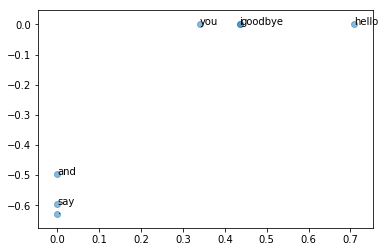

In [24]:
%pylab inline
# SVD
U, S, V = np.linalg.svd(W)

# plot
from matplotlib import pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [37]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                pass
                #line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                #                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                #ax.add_artist(line)

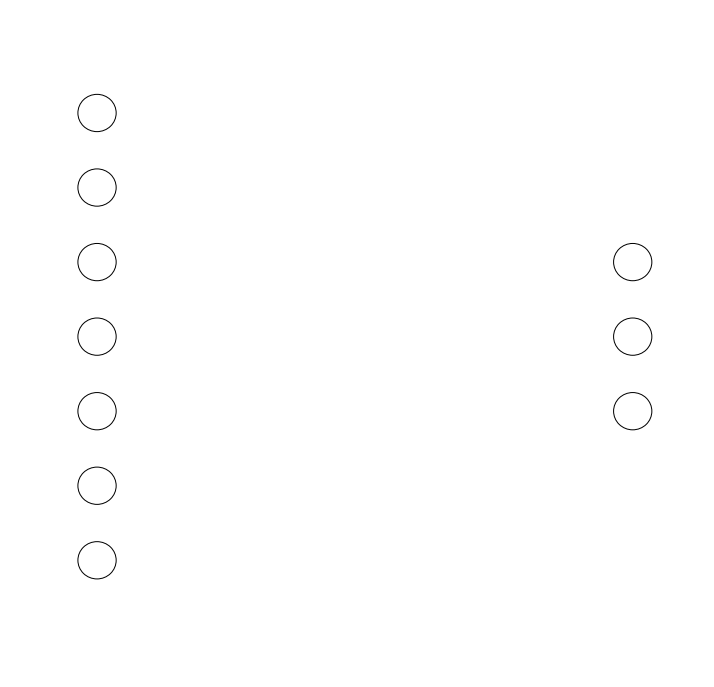

In [40]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [7, 3])
#fig.savefig('nn.png')

In [35]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

In [36]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 2.279 -0.246 -4.729  3.355 -3.002  0.301  1.122]]


In [41]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [45]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, 1)
print(contexts, target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]] [1 2 3 4 1 5]


In [48]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1
    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1
    return one_hot

In [49]:
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, 1)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [50]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

In [51]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [53]:
# coding: utf-8
#from common.np import *  # import numpy as np
#from common.config import GPU
#from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx


class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoidの出力
        self.t = None  # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [55]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [57]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [71]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

In [72]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()

In [73]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [74]:
# coding: utf-8

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 245 |  iter 1 / 2 | time 0[s] | loss 1.17
| epoch 246 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 247 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 248 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 249 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 250 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 251 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 252 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 253 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 254 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 255 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 256 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 257 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 258 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 259 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 260 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 261 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 262 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 263 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 264 |  iter 1 / 2 | time 0[s] | loss 1.02


| epoch 480 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 481 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 482 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 483 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 484 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 485 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 486 |  iter 1 / 2 | time 0[s] | loss 0.75
| epoch 487 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 488 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 489 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 490 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 491 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 492 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 493 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 494 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 495 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 496 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 497 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 498 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 499 |  iter 1 / 2 | time 0[s] | loss 0.51


| epoch 740 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 741 |  iter 1 / 2 | time 0[s] | loss 0.28
| epoch 742 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 743 |  iter 1 / 2 | time 0[s] | loss 0.28
| epoch 744 |  iter 1 / 2 | time 0[s] | loss 0.47
| epoch 745 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 746 |  iter 1 / 2 | time 0[s] | loss 0.24
| epoch 747 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 748 |  iter 1 / 2 | time 0[s] | loss 0.37
| epoch 749 |  iter 1 / 2 | time 0[s] | loss 0.35
| epoch 750 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 751 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 752 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 753 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 754 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 755 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 756 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 757 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 758 |  iter 1 / 2 | time 0[s] | loss 0.35
| epoch 759 |  iter 1 / 2 | time 0[s] | loss 0.49


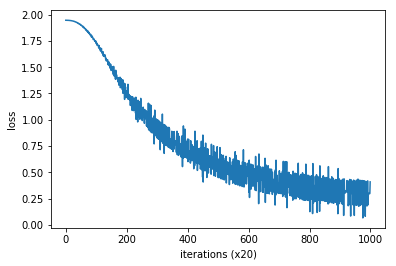

you [ 1.356 -1.592  0.96  -0.922 -0.942]
say [ 0.322 -1.147 -1.191  1.191  1.199]
goodbye [-0.217  0.745  1.133 -1.124 -1.106]
and [ 1.812 -0.561 -0.939  0.98   0.982]
i [-0.211  0.748  1.141 -1.12  -1.115]
hello [ 1.344 -1.6    0.932 -0.923 -0.918]
. [-1.657 -1.274 -1.079  1.074  1.137]


In [75]:

import sys

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])